In [1]:
import numpy as np
import matplotlib.pyplot as plt
from collections import Counter
import itertools
import random
import pandas as pd
import seaborn as sns
import matplotlib 
import math

sns.set(color_codes=True)
matplotlib.rcParams['figure.figsize'] = (25, 4)

In [2]:
data = []


params = [ {'pi': 0.3, 'mu': 100, 'sigma': 1},
         {'pi': 0.2, 'mu': 0, 'sigma': 3},
         {'pi': 0.3, 'mu': 20, 'sigma': 5},
         {'pi': 0.2, 'mu': 70, 'sigma': 2}
        ]

total_toss = 2500

num_cluster = len(params)

In [3]:
Z = [np.random.choice(num_cluster, 1, p=[params[i]['pi'] for i in range(num_cluster)])[0] for toss in range(total_toss)]

In [4]:
data = [(np.random.normal(params[z]["mu"], params[z]["sigma"], 1))[0] for z in Z]

Text(0.5, 1.0, 'Mixture of Gaussian')

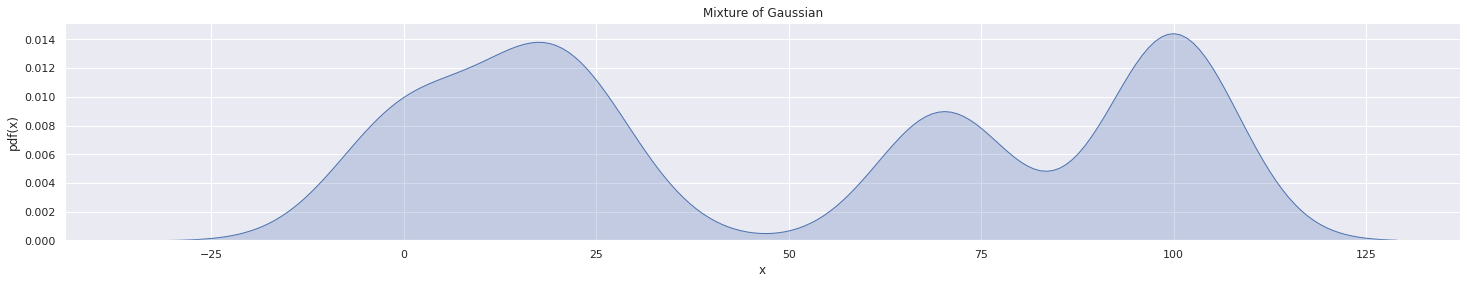

In [5]:
ax = sns.kdeplot(data, shade=True)
plt.xlabel("x")
plt.ylabel("pdf(x)")
plt.title("Mixture of Gaussian")

In [6]:
def sample_mu_sigma(data, m=50, c=1, a=7, b=20):

    N = np.size(data)

    C = c + N
    A = a + (N/2)
    M = ((c*m) + (np.sum(data)))/C
    B = b + (0.5 * (c*m**2 - C*M**2 + np.sum(data**2)))

    precision = np.random.gamma(shape=A, scale=1/B, size=1)[0]

    sigma = np.sqrt(1/precision)
    c_root = np.sqrt(1/C)

    mu = np.random.normal(loc=M, scale=sigma*c_root, size=1)[0]

    return mu, sigma

def sample_mu_sigma_without_data(m=50, c=1, a=7, b=20):

    precision = np.random.gamma(shape=a, scale=1/b, size=1)[0]

    sigma = np.sqrt(1/precision)

    c_root = np.sqrt(1/c)

    mu = np.random.normal(loc=m, scale=sigma*c_root, size=1)[0]

    return mu, sigma

In [7]:
def gaussian_pdf(x, mean, sigma):
    return np.exp(-1.0 * ((x - mean)**2)/(2 * sigma**2))/np.sqrt(2 * np.pi * sigma**2)

In [8]:
def generate_cluster(data, x_i, random_Z):
    clusters = {}
    for k in cluster_type:
        clusters[k] = []

    for index, x in enumerate(data):
        if x == x_i:
            continue
        clusters[random_Z[index]].append(x)
    return clusters

In [9]:
def calc_prob(cluster_type, x_i, data, random_Z, init_mu, init_sig):
    clusters = generate_cluster(data, x_i, random_Z)
    
    A = 1.0
    C = len(data)
    
    for k in cluster_type:
        if len(clusters[k]) == 0:
            continue
        init_mu[k], init_sig[k] = sample_mu_sigma(np.array(clusters[k]))

    prob = []
    
    random_Z_count = Counter(random_Z)
    
    for k in cluster_type:
        prob_k = gaussian_pdf(x_i, init_mu[k], init_sig[k])
        pr = (random_Z_count[k] / (A - 1 + C)) * prob_k
        
        prob.append(pr)
    
    new_mu, new_sig = sample_mu_sigma_without_data()
    new_pr = (A / (C + A - 1)) * gaussian_pdf(x_i, new_mu, new_sig)
    prob = prob + [new_pr]
    
    return prob

In [10]:
def remove_unwanted_cluster(data, random_Z, cluster_type, init_mu, init_sig):

    deleted_cluster_type = []

    clusters = {}

    for k in cluster_type:
        clusters[k] = []

    for index,d in enumerate(data):
        clusters[random_Z[index]].append(d)

    for k in cluster_type:
        if len(clusters[k]) == 0:
            deleted_cluster_type.append(k)

    for d in deleted_cluster_type:

        cluster_type.remove(d)
        del init_mu[d]
        del init_sig[d]

In [11]:
# Initialize the parameters
init_mu = {}
init_sig = {}

cluster_type = []

initial_cluster_number = 10 

for i in range(initial_cluster_number):
    cluster_type.append(i)
    init_mu[i] = 0
    init_sig[i] = 0

In [12]:
def set_data_type(data, cluster_type):

    random_Z = []

    k_cluster = len(cluster_type)

    for i in range(len(data)):
        random_Z.append(np.random.choice(cluster_type, 1, p=[1/k_cluster for i in range(k_cluster)])[0])

    return random_Z

In [13]:
random_Z = set_data_type(data, cluster_type)

### Calculate Log likelihood of the data 

In [14]:
actual_cluster_type = list(range(len(params)))

params_mu = {}
params_sig = {}

for i in range(len(params)):
    params_mu[i] = params[i]["mu"]
    params_sig[i] = params[i]["sigma"]    

In [15]:
def actual_calc_prob(x, X, random_Z, random_Z_count, N):
    prob = []
    
    for k in actual_cluster_type:
        prob_k = gaussian_pdf(x, params_mu[k], params_sig[k])
        pr = (random_Z_count[k] / (A - 1 + N)) * prob_k
        
        prob.append(pr)
    
    return prob

In [16]:
import math
A =0.1 

Z_count = Counter(Z)
N = len(data)

for i, (x, z) in enumerate(zip(data, Z)):
    prob = actual_calc_prob(x, data, Z, Z_count, N)
    total_prob = np.sum(prob)

    norm_prob = [p/total_prob for p in prob]

    actual_data_likelihood = np.log(np.sum(prob))

In [17]:
actual_data_likelihood

-3.9731311537733798

In [18]:
actual_total_likelihood = 45*[actual_data_likelihood]

## *********

In [19]:
import math

total_likelihood = []


for o in range(15):
    
    data_likelihood = []
    for i, (x, z) in enumerate(zip(data, random_Z)):
        prob = calc_prob(cluster_type, x, data, random_Z, init_mu, init_sig)
        total_prob = np.sum(prob)
        
        norm_prob = [p/total_prob for p in prob]
        
        new_cluster_type = [max(cluster_type) + 1]
        random_Z[i] = np.random.choice(cluster_type + new_cluster_type, 1, p=norm_prob)[0]
        
        if random_Z[i] not in cluster_type: 
            cluster_type.append(random_Z[i])
        data_likelihood.append(np.log(np.sum(prob)))
        
    remove_unwanted_cluster(data, random_Z, cluster_type, init_mu, init_sig)

    
    total_likelihood.append(np.sum(data_likelihood))
    print(f"Cluster Size: {len(cluster_type)} in Iteration: {o+1}")

Cluster Size: 10 in Iteration: 1
Cluster Size: 10 in Iteration: 2
Cluster Size: 10 in Iteration: 3
Cluster Size: 10 in Iteration: 4
Cluster Size: 10 in Iteration: 5
Cluster Size: 10 in Iteration: 6
Cluster Size: 10 in Iteration: 7
Cluster Size: 10 in Iteration: 8
Cluster Size: 10 in Iteration: 9
Cluster Size: 7 in Iteration: 10
Cluster Size: 6 in Iteration: 11
Cluster Size: 5 in Iteration: 12
Cluster Size: 5 in Iteration: 13
Cluster Size: 5 in Iteration: 14
Cluster Size: 4 in Iteration: 15


In [20]:
remaining_Z = np.unique(np.array(random_Z)).tolist()

## Randomly change 40% of computed labels 

In [21]:
for i in range(len(random_Z)):
    if np.random.uniform() < 0.4:
        random_Z[i] = np.random.choice(remaining_Z)

In [22]:
for o in range(25):
    
    data_likelihood = []
    for i, (x, z) in enumerate(zip(data, random_Z)):
        prob = calc_prob(cluster_type, x, data, random_Z, init_mu, init_sig)
        total_prob = np.sum(prob)
        
        norm_prob = [p/total_prob for p in prob]
        
        new_cluster_type = [max(cluster_type) + 1]
        random_Z[i] = np.random.choice(cluster_type + new_cluster_type, 1, p=norm_prob)[0]
        
        if random_Z[i] not in cluster_type: 
            cluster_type.append(random_Z[i])
        data_likelihood.append(np.log(np.sum(prob)))
        
    remove_unwanted_cluster(data, random_Z, cluster_type, init_mu, init_sig)

    
    total_likelihood.append(np.sum(data_likelihood))
    print(f"Cluster Size: {len(cluster_type)} in Iteration: {o+16}")

Cluster Size: 4 in Iteration: 16
Cluster Size: 4 in Iteration: 17
Cluster Size: 4 in Iteration: 18
Cluster Size: 4 in Iteration: 19
Cluster Size: 4 in Iteration: 20
Cluster Size: 4 in Iteration: 21
Cluster Size: 4 in Iteration: 22
Cluster Size: 4 in Iteration: 23
Cluster Size: 4 in Iteration: 24
Cluster Size: 4 in Iteration: 25
Cluster Size: 4 in Iteration: 26
Cluster Size: 4 in Iteration: 27
Cluster Size: 4 in Iteration: 28
Cluster Size: 4 in Iteration: 29
Cluster Size: 4 in Iteration: 30
Cluster Size: 4 in Iteration: 31
Cluster Size: 4 in Iteration: 32
Cluster Size: 4 in Iteration: 33
Cluster Size: 4 in Iteration: 34
Cluster Size: 4 in Iteration: 35
Cluster Size: 4 in Iteration: 36
Cluster Size: 4 in Iteration: 37
Cluster Size: 4 in Iteration: 38
Cluster Size: 4 in Iteration: 39
Cluster Size: 4 in Iteration: 40


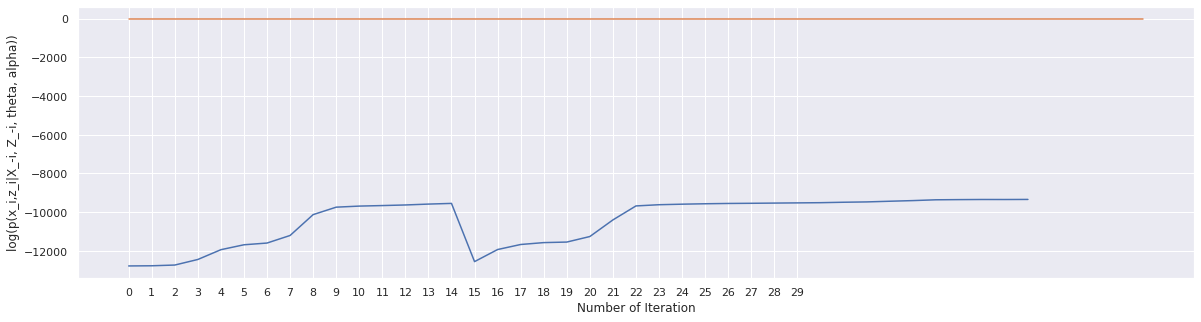

In [23]:
plt.figure(figsize=(20, 5))
plt.plot(total_likelihood)
plt.plot(actual_total_likelihood)
plt.xlabel("Number of Iteration")
plt.ylabel("log(p(x_i,z_i|X_-i, Z_-i, theta, alpha))")
plt.xticks([i for i in range(30)])
plt.show()

In [24]:
print("Estimated Parameters")
result = Counter(random_Z)
clusters = set(result.keys())
print("Remainings clusters: ",clusters)
final_clusters_param = []
C = len(data)
for i in clusters:
    single_cluster = {}
    single_cluster["pi"] = result[i]/C
    single_cluster["mu"] = init_mu[i]
    single_cluster["sigma"] = init_sig[i]
    final_clusters_param.append(single_cluster)

Estimated Parameters
Remainings clusters:  {0, 1, 3, 4}


In [25]:
params

[{'pi': 0.3, 'mu': 100, 'sigma': 1},
 {'pi': 0.2, 'mu': 0, 'sigma': 3},
 {'pi': 0.3, 'mu': 20, 'sigma': 5},
 {'pi': 0.2, 'mu': 70, 'sigma': 2}]

In [26]:
final_clusters_param

[{'pi': 0.1872, 'mu': 0.023937672333734922, 'sigma': 3.8993928158542213},
 {'pi': 0.1936, 'mu': 70.12631149645192, 'sigma': 2.0958476627171025},
 {'pi': 0.3052, 'mu': 100.00461239735432, 'sigma': 2.1211376810224785},
 {'pi': 0.314, 'mu': 19.981530150656738, 'sigma': 5.052526449156201}]

In [27]:
plt.rcParams["figure.figsize"] = (10,3)

Actual Distributions


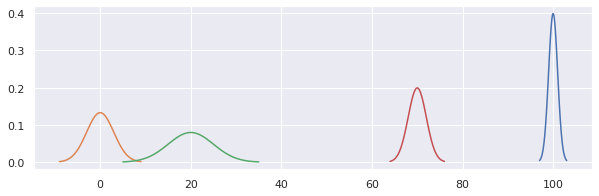

In [28]:
import scipy.stats as stats
print("Actual Distributions")
for i in range(len(params)):
    x = np.linspace(params[i]['mu'] - 3*params[i]['sigma'], params[i]['mu'] + 3*params[i]['sigma'], 100)
    plt.plot(x, stats.norm.pdf(x, params[i]['mu'], params[i]['sigma']))
plt.show()

Computed Distributions


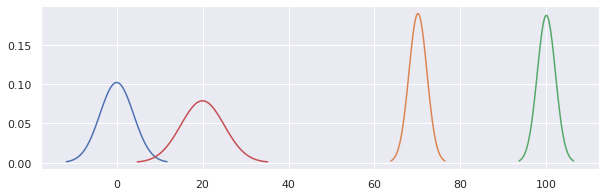

In [29]:
import scipy.stats as stats
print("Computed Distributions")
for i in range(len(final_clusters_param)):
    x = np.linspace(final_clusters_param[i]['mu'] - 3*final_clusters_param[i]['sigma'], final_clusters_param[i]['mu'] + 3*final_clusters_param[i]['sigma'], 100)
    plt.plot(x, stats.norm.pdf(x, final_clusters_param[i]['mu'], final_clusters_param[i]['sigma']))
plt.show()